In [1]:
import os

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
def load_data():
    DB_USER = os.getenv("POSTGRES_USER")
    DB_PASSWORD = os.getenv("POSTGRES_PASSWORD")
    DB_HOST = os.getenv("POSTGRES_HOST")
    DB_PORT = os.getenv("POSTGRES_PORT")
    DB_NAME = os.getenv("POSTGRES_DB") 

    connection_str = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    engine = create_engine(connection_str)

    query = """
    SELECT
        acidentes.id, 
        classificacao_acidente,
        regiao,
        tipo_acidente,
        causa_acidente,
        DATE_PART('HOUR', data_completa) AS hora,
        uso_solo,
        br,
        tipo_veiculo,
        latitude,
        longitude
    FROM relational.acidentes
    INNER JOIN relational.envolvidos ON acidentes.id = envolvidos.id_acidente"""

    query_dbscan = """
    SELECT
        id,
        classificacao_acidente,
        regiao,
        causa_acidente,
        latitude,
        longitude
    FROM relational.acidentes"""

    df_query = pd.read_sql(query, con=engine)
    df_query_dbscan = pd.read_sql(query_dbscan, con=engine)
    return df_query, df_query_dbscan

df, df_dbscan = load_data()

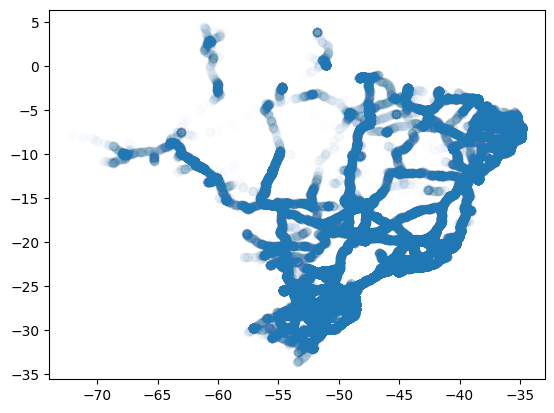

In [3]:
lat_long = df_dbscan[['latitude', 'longitude']]
lat, long = df_dbscan.latitude, df_dbscan.longitude

plt.scatter(long, lat, alpha=0.01)

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import make_scorer, silhouette_score as ss
from sklearn.model_selection import RandomizedSearchCV

In [5]:
X = lat_long.to_numpy()

In [6]:
epsilons = np.linspace(0.03, 1, num=5)
epsilons

array([0.03  , 0.2725, 0.515 , 0.7575, 1.    ])

In [7]:
num_samples = np.arange(30, 80, step=18)
num_samples

array([30, 48, 66])

In [8]:
import itertools

combinations = list(itertools.product(epsilons, num_samples))

In [9]:
N = len(combinations)
N

15

In [10]:
def get_scores_and_labels(combinations, X):
    scores = []
    all_labels_list = []

    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = dbscan_cluster_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
    
        if -1 in labels_set:
            num_clusters -= 1
    
        if (num_clusters < 2) or (num_clusters > 50):
         scores.append(-10)
        all_labels_list.append('bad')
        c = (eps, num_samples)
        print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
        continue
    
    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]

    return {'best_epsilon': best_parameters[0],
        'best_min_samples': best_parameters[1], 
        'best_labels': best_labels,
        'best_score': best_score}

: 

In [11]:
best_dict = get_scores_and_labels(combinations, X)

Combination (0.03, 30) on iteration 1 of 15 has 564 clusters. Moving on
Combination (0.03, 48) on iteration 2 of 15 has 411 clusters. Moving on
Combination (0.03, 66) on iteration 3 of 15 has 322 clusters. Moving on
Combination (0.27249999999999996, 30) on iteration 4 of 15 has 28 clusters. Moving on
Combination (0.27249999999999996, 48) on iteration 5 of 15 has 33 clusters. Moving on
Combination (0.27249999999999996, 66) on iteration 6 of 15 has 42 clusters. Moving on


In [ ]:
df.drop_duplicats(subset='id', keep='first', inplace=True)
df.drop(columns=['id'], inplace=True)

AttributeError: 'DataFrame' object has no attribute 'drop_duplicats'

In [ ]:
df.head()

,classificacao_acidente,regiao,tipo_acidente,causa_acidente,hora,uso_solo,br,tipo_veiculo
0,Sem Vítimas,Norte,Colisão transversal,Ingestão de Álcool,0.0,Urbano,BR-319,Automóvel
2,Com Vítimas Feridas,Sul,Colisão frontal,Condutor Dormindo,2.0,Urbano,BR-470,Automóvel
6,Sem Vítimas,Sul,Colisão lateral,Ingestão de Álcool,3.0,Rural,BR-101,Automóvel
12,Com Vítimas Feridas,Norte,Saída de leito carroçável,Falta de Atenção à Condução,5.0,Rural,BR-316,Caminhão
14,Com Vítimas Feridas,Centro-Oeste,Saída de leito carroçável,Ingestão de Álcool,6.0,Rural,BR-153,Automóvel


In [ ]:
causas_comuns = df['causa_acidente'].value_counts()[df['causa_acidente'].value_counts() > 2000].index
df = df[df['causa_acidente'].isin(causas_comuns)]
df['causa_acidente'].value_counts()

causa_acidente
Reação tardia ou ineficiente do condutor                     25035
Velocidade Incompatível                                      23995
Falta de Atenção à Condução                                  22478
Ausência de reação do condutor                               22108
Acessar a via sem observar a presença dos outros veículos    15424
Condutor deixou de manter distância do veículo da frente     13389
Ingestão de álcool pelo condutor                             12261
Manobra de mudança de faixa                                  10409
Condutor Dormindo                                             8795
Desobediência às normas de trânsito pelo condutor             8344
Demais falhas mecânicas ou elétricas                          8230
Ultrapassagem Indevida                                        5416
Transitar na contramão                                        5110
Avarias e/ou desgaste excessivo no pneu                       4828
Animais na Pista                               

In [ ]:
df.loc[df['causa_acidente'] == 'Ausência de reação do condutor', 'causa_acidente'] = 'Reação tardia ou ineficiente do condutor'
df.loc[df['causa_acidente'] == 'Ingestão de álcool pelo condutor', 'causa_acidente'] = 'Ingestão de Álcool'
df.loc[df['causa_acidente'] == 'Demais falhas mecânicas ou elétricas', 'causa_acidente'] = 'Defeito Mecânico no Veículo'

In [ ]:
# One hot encoding

X = df.drop(columns=['classificacao_acidente'])
y = df['classificacao_acidente']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['regiao', 'tipo_acidente', 'causa_acidente', 'uso_solo', 'tipo_veiculo', 'br']
numerical_features = ['hora']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 350 ,400],
    'classifier__max_depth': [25, 30, 33, 35],
    'classifier__min_samples_split': [10, 15, 20, 25],
    'classifier__min_samples_leaf': [2, 3, 5, 7]
}


In [ ]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, 
                                   n_iter=12, cv=5, verbose=1, 
                                   random_state=42, n_jobs=7)

In [ ]:
random_search.fit(X_train, y_train)

# Resultados
best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia nos dados de teste: {accuracy:.2f}')

Acurácia nos dados de teste: 0.78


In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

 Com Vítimas Fatais       0.57      0.01      0.02      2839
Com Vítimas Feridas       0.78      0.98      0.87     33198
        Sem Vítimas       0.74      0.21      0.33      8116

           accuracy                           0.78     44153
          macro avg       0.69      0.40      0.40     44153
       weighted avg       0.76      0.78      0.71     44153



In [ ]:
# Salvando o modelo

import joblib

joblib.dump(pipeline, 'model/model.pkl')

['model/model.pkl']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [ ]:
X_new = pipeline.named_steps['preprocessor'].transform(X)
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_new)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=2)
clusters = dbscan.fit_predict(X_scaled)

In [ ]:
df['cluster'] = clusters
df['cluster'].value_counts()

cluster
-1        55693
 5547       639
 5635       604
 5837       588
 6225       576
          ...  
 49385        2
 49384        2
 35508        2
 49382        2
 39285        2
Name: count, Length: 67008, dtype: int64

In [ ]:
print("Tamanho de X_scaled:", X_scaled.shape)
print("Tamanho dos clusters:", clusters.shape)

Tamanho de X_scaled: (563744, 188)
Tamanho dos clusters: (563744,)


In [ ]:
df['cluster'].value_counts()[:10]

cluster
-1       55693
 5547      639
 5635      604
 5837      588
 6225      576
 6291      542
 78        527
 5979      524
 5515      461
 40        453
Name: count, dtype: int64

In [ ]:
df[df['cluster'] == 40].head(10)

,classificacao_acidente,regiao,tipo_acidente,causa_acidente,hora,uso_solo,br,tipo_veiculo,cluster
102,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,16.0,Rural,BR-381,Automóvel,40
597,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,14.0,Rural,BR-381,Automóvel,40
598,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,14.0,Rural,BR-381,Automóvel,40
599,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,14.0,Rural,BR-381,Automóvel,40
1313,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,10.0,Rural,BR-381,Automóvel,40
1314,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,10.0,Rural,BR-381,Automóvel,40
1578,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,12.0,Rural,BR-381,Automóvel,40
1579,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,12.0,Rural,BR-381,Automóvel,40
2581,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,8.0,Rural,BR-381,Automóvel,40
2582,Com Vítimas Feridas,Sudeste,Capotamento,Velocidade Incompatível,8.0,Rural,BR-381,Automóvel,40


In [ ]:
# Salvando os dados

df.to_csv('data/acidentes_cluster.csv', index=False)